# Failed Simulations Analysis

This notebook analyzes the parameters that lead to failed ODE simulations. We'll visualize the distribution of parameter values for failed vs successful simulations to identify patterns.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
import os
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## Load Data

In [3]:
n_samples = 32768

sim_dir = f'outputs/simulations/output_{n_samples}_samples'

# Load the input samples
df = pd.read_csv(os.path.join(sim_dir, f'input_samples_{n_samples}.csv'))
print(f"Total samples: {len(df)}")
print(f"Number of parameters: {len(df.columns)}")
print(f"Parameters: {list(df.columns)}")

# Load failed simulation indices
with open(os.path.join(sim_dir, 'bool_indices.json'), 'r') as f:
    failed_indices = json.load(f)

print(f"\nNumber of failed simulations: {len(failed_indices)}")
print(f"Failure rate: {len(failed_indices)/len(df)*100:.2f}%")
print(f"Failed indices: {failed_indices}")

Total samples: 32768
Number of parameters: 35
Parameters: ['ao.r', 'ao.c', 'art.r', 'art.c', 'ven.r', 'ven.c', 'av.r', 'mv.r', 'la.E_pas', 'la.E_act', 'la.v_ref', 'la.k_pas', 'lv.E_pas', 'lv.E_act', 'lv.v_ref', 'lv.k_pas', 'T', 'ao.l', 'ao.v_ref', 'art.l', 'art.v_ref', 'ven.l', 'ven.v_ref', 'la.v', 'la.delay', 'la.t_tr', 'la.tau', 'la.t_max', 'lv.delay', 'lv.t_tr', 'lv.tau', 'lv.t_max', 'ao.v', 'art.v', 'ven.v']

Number of failed simulations: 128
Failure rate: 0.39%
Failed indices: [31, 438, 855, 872, 1211, 1459, 1489, 1608, 1840, 2183, 2487, 3543, 3675, 3959, 4254, 4348, 4407, 4437, 4819, 5463, 5617, 5698, 5904, 6092, 6544, 6764, 6879, 6887, 7025, 7127, 7464, 7664, 8159, 8211, 8664, 8811, 9262, 9607, 9935, 9988, 10086, 10279, 10638, 10760, 11203, 11500, 12055, 12135, 12488, 12846, 12876, 12936, 13123, 13315, 13727, 13738, 13868, 13902, 14346, 14483, 14755, 15136, 15439, 15720, 15951, 16019, 16255, 16260, 16552, 17376, 17655, 17863, 18244, 18791, 18939, 19016, 19532, 20008, 20042, 2020

## Create Success/Failure Labels

In [4]:
# Create a binary column for failed simulations
df['failed'] = False
df.loc[failed_indices, 'failed'] = True

# Separate successful and failed simulations
failed_df = df[df['failed'] == True].copy()
success_df = df[df['failed'] == False].copy()

print(f"Successful simulations: {len(success_df)}")
print(f"Failed simulations: {len(failed_df)}")

# Get parameter columns (exclude the 'failed' column)
param_cols = [col for col in df.columns if col != 'failed']
print(f"\nParameter columns ({len(param_cols)}): {param_cols}")

Successful simulations: 32640
Failed simulations: 128

Parameter columns (35): ['ao.r', 'ao.c', 'art.r', 'art.c', 'ven.r', 'ven.c', 'av.r', 'mv.r', 'la.E_pas', 'la.E_act', 'la.v_ref', 'la.k_pas', 'lv.E_pas', 'lv.E_act', 'lv.v_ref', 'lv.k_pas', 'T', 'ao.l', 'ao.v_ref', 'art.l', 'art.v_ref', 'ven.l', 'ven.v_ref', 'la.v', 'la.delay', 'la.t_tr', 'la.tau', 'la.t_max', 'lv.delay', 'lv.t_tr', 'lv.tau', 'lv.t_max', 'ao.v', 'art.v', 'ven.v']


## 1. Distribution Comparison for All Parameters

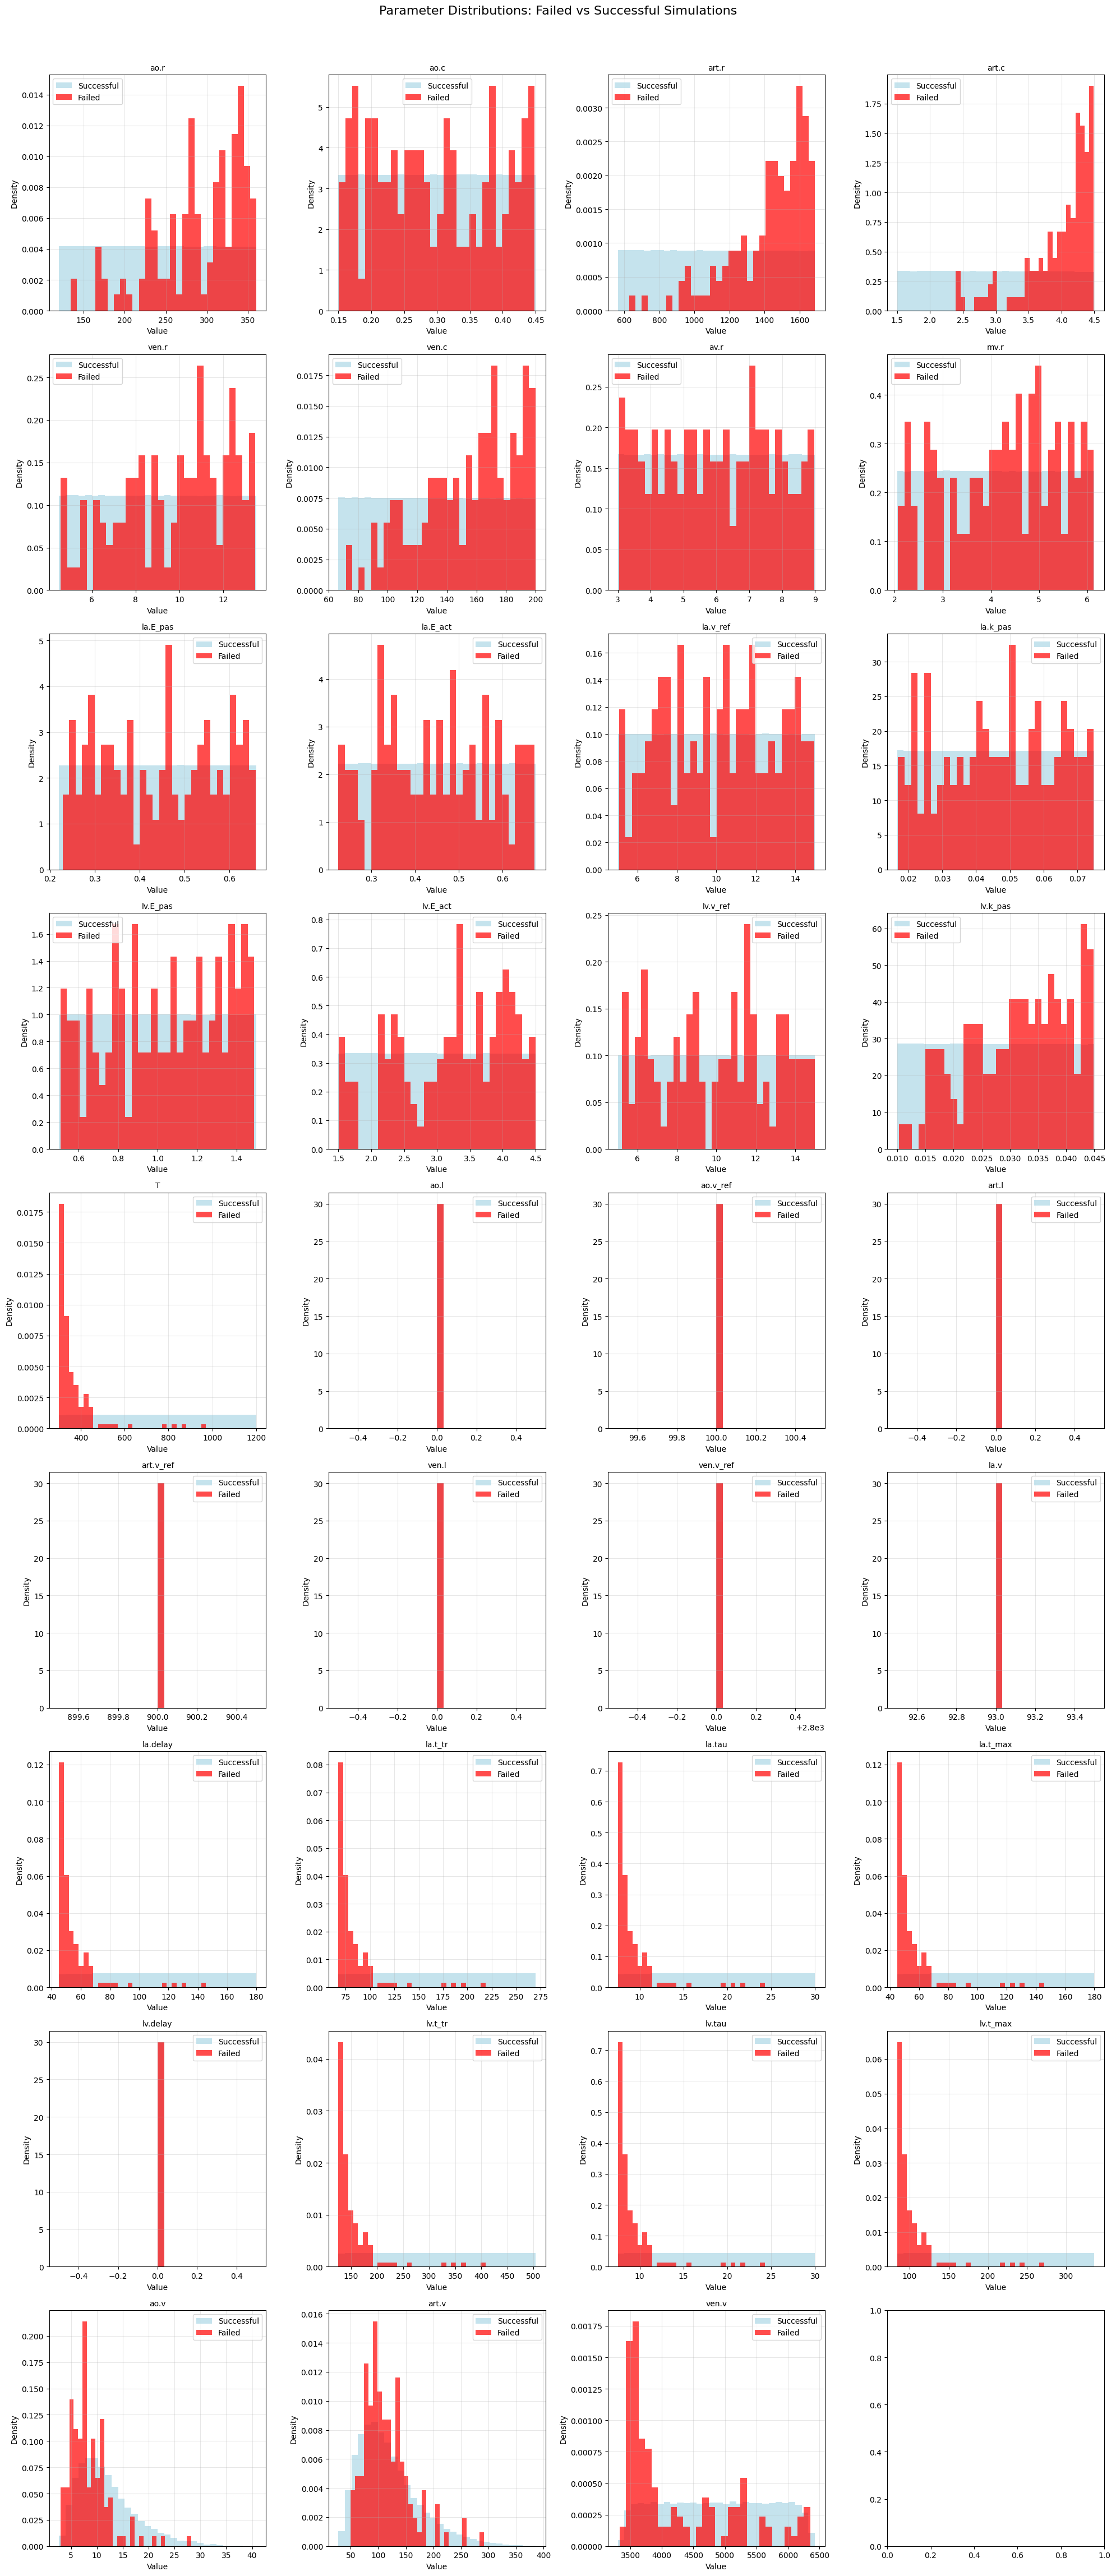

In [ ]:
# Create subplots for all parameters
n_params = len(param_cols)
n_cols = 4
n_rows = (n_params + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

for i, param in enumerate(param_cols):
    ax = axes[i]
    
    # Plot histograms
    ax.hist(success_df[param], bins=30, alpha=0.7, label='Successful', color='lightblue', density=True)
    ax.hist(failed_df[param], bins=30, alpha=0.7, label='Failed', color='red', density=True)
    
    ax.set_title(f'{param}', fontsize=10)
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for i in range(n_params, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.suptitle('Parameter Distributions: Failed vs Successful Simulations', fontsize=16, y=1.02)
plt.show()

## 2. Statistical Summary of Differences

In [ ]:
# Calculate statistics for each parameter
stats_summary = []

for param in param_cols:
    success_values = success_df[param]
    failed_values = failed_df[param]
    
    # Perform t-test
    from scipy.stats import ttest_ind, mannwhitneyu
    
    try:
        t_stat, p_value = ttest_ind(success_values, failed_values)
        u_stat, p_value_mw = mannwhitneyu(success_values, failed_values, alternative='two-sided')
    except:
        t_stat, p_value = np.nan, np.nan
        u_stat, p_value_mw = np.nan, np.nan
    
    stats_summary.append({
        'Parameter': param,
        'Success_Mean': success_values.mean(),
        'Success_Std': success_values.std(),
        'Failed_Mean': failed_values.mean(),
        'Failed_Std': failed_values.std(),
        'Mean_Difference': failed_values.mean() - success_values.mean(),
        'T_Test_P_Value': p_value,
        'MW_Test_P_Value': p_value_mw
    })

stats_df = pd.DataFrame(stats_summary)
stats_df['Significant'] = stats_df['T_Test_P_Value'] < 0.05

# Sort by absolute mean difference
stats_df['Abs_Mean_Diff'] = abs(stats_df['Mean_Difference'])
stats_df = stats_df.sort_values('Abs_Mean_Diff', ascending=False)

print("Statistical Summary (sorted by absolute mean difference):")
print(stats_df[['Parameter', 'Success_Mean', 'Failed_Mean', 'Mean_Difference', 'T_Test_P_Value', 'Significant']].round(4))

Statistical Summary (sorted by absolute mean difference):
    Parameter  Success_Mean  Failed_Mean  Mean_Difference  T_Test_P_Value  \
34      ven.v     4871.2782    4175.9871        -695.2911          0.0138   
16          T      751.6919     366.6963        -384.9956          0.0000   
2       art.r     1123.7267    1413.4807         289.7540          0.0076   
29    lv.t_tr      315.7106     154.0124        -161.6981          0.0000   
31   lv.t_max      210.4737     102.6750        -107.7988          0.0000   
25    la.t_tr      169.1307      82.5067         -86.6240          0.0000   
27   la.t_max      112.7538      55.0044         -57.7493          0.0000   
24   la.delay      112.7538      55.0044         -57.7493          0.0000   
0        ao.r      239.7799     289.8758          50.0959          0.0304   
5       ven.c      133.1359     170.4866          37.3507          0.0037   
33      art.v      119.8477     103.7646         -16.0831          0.3925   
26     la.tau     

## 3. Box Plots for Top Discriminating Parameters

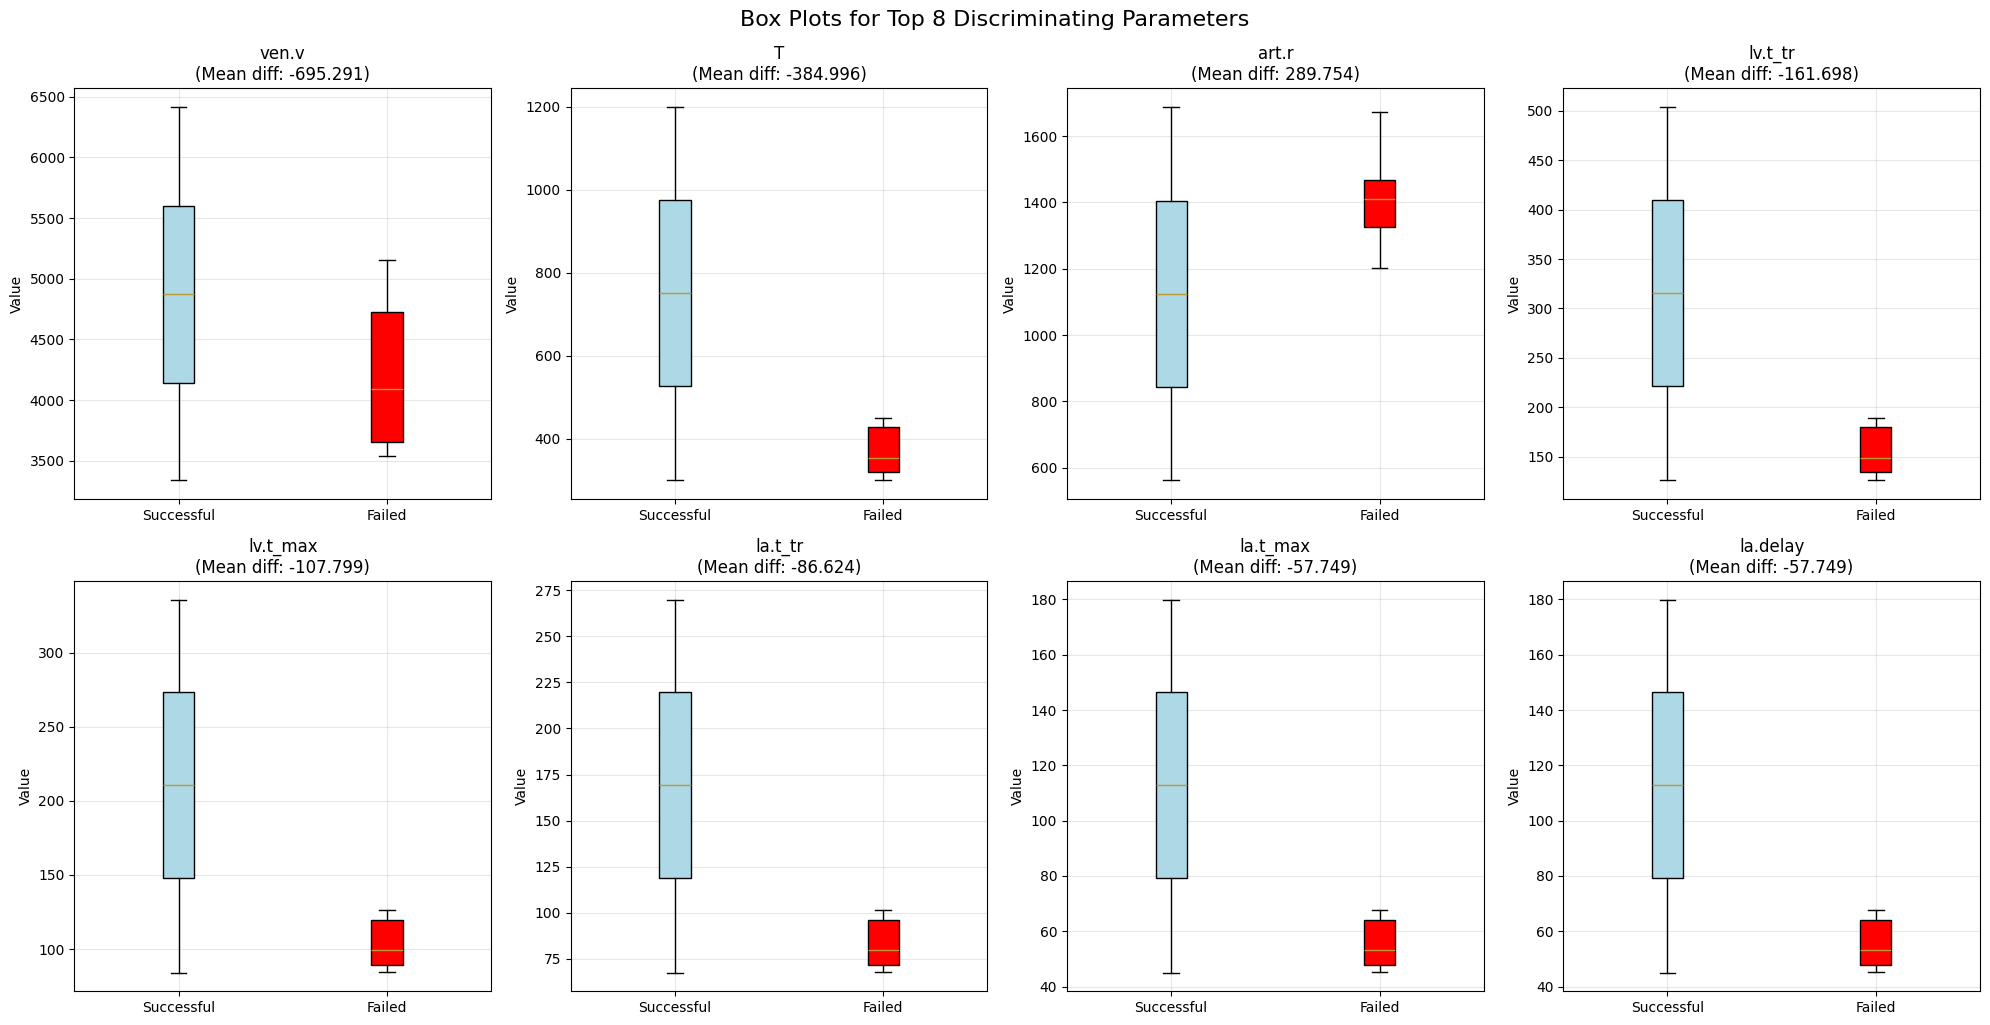

In [ ]:
# Select top 8 parameters with largest differences
top_params = stats_df.head(8)['Parameter'].values

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, param in enumerate(top_params):
    ax = axes[i]
    
    # Prepare data for box plot
    data_to_plot = [success_df[param], failed_df[param]]
    
    box_plot = ax.boxplot(data_to_plot, labels=['Successful', 'Failed'], patch_artist=True)
    box_plot['boxes'][0].set_facecolor('lightblue')
    box_plot['boxes'][1].set_facecolor('red')
    
    ax.set_title(f'{param}\n(Mean diff: {stats_df[stats_df["Parameter"]==param]["Mean_Difference"].iloc[0]:.3f})')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Box Plots for Top 8 Discriminating Parameters', fontsize=16, y=1.02)
plt.show()

## 4. Principal Component Analysis (PCA)

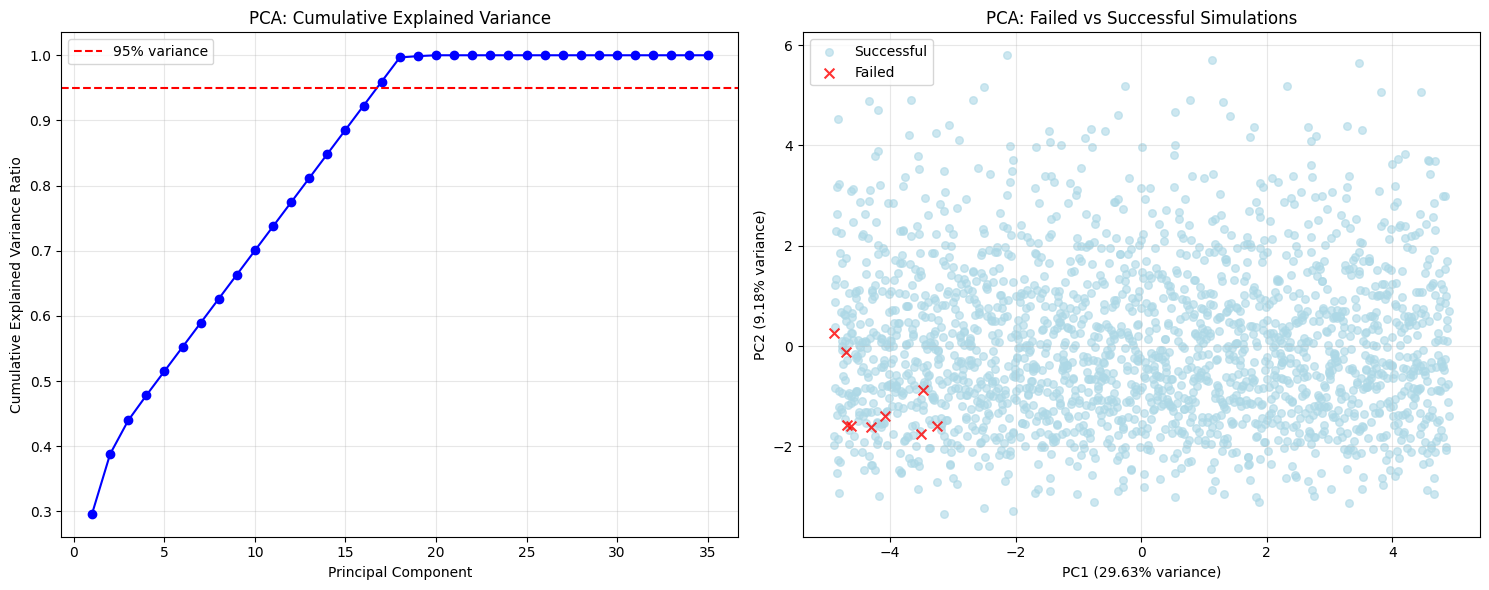

First 5 PCs explain 51.52% of the variance
First 10 PCs explain 70.04% of the variance


In [ ]:
# Prepare data for PCA
X = df[param_cols]
y = df['failed']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Plot explained variance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Explained variance ratio
ax1.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), 'bo-')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Cumulative Explained Variance Ratio')
ax1.set_title('PCA: Cumulative Explained Variance')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
ax1.legend()

# 2D PCA scatter plot
scatter = ax2.scatter(X_pca[~y, 0], X_pca[~y, 1], c='lightblue', alpha=0.6, label='Successful', s=30)
scatter = ax2.scatter(X_pca[y, 0], X_pca[y, 1], c='red', alpha=0.8, label='Failed', s=50, marker='x')
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
ax2.set_title('PCA: Failed vs Successful Simulations')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"First 5 PCs explain {sum(pca.explained_variance_ratio_[:5]):.2%} of the variance")
print(f"First 10 PCs explain {sum(pca.explained_variance_ratio_[:10]):.2%} of the variance")

## 5. Feature Importance from PCA

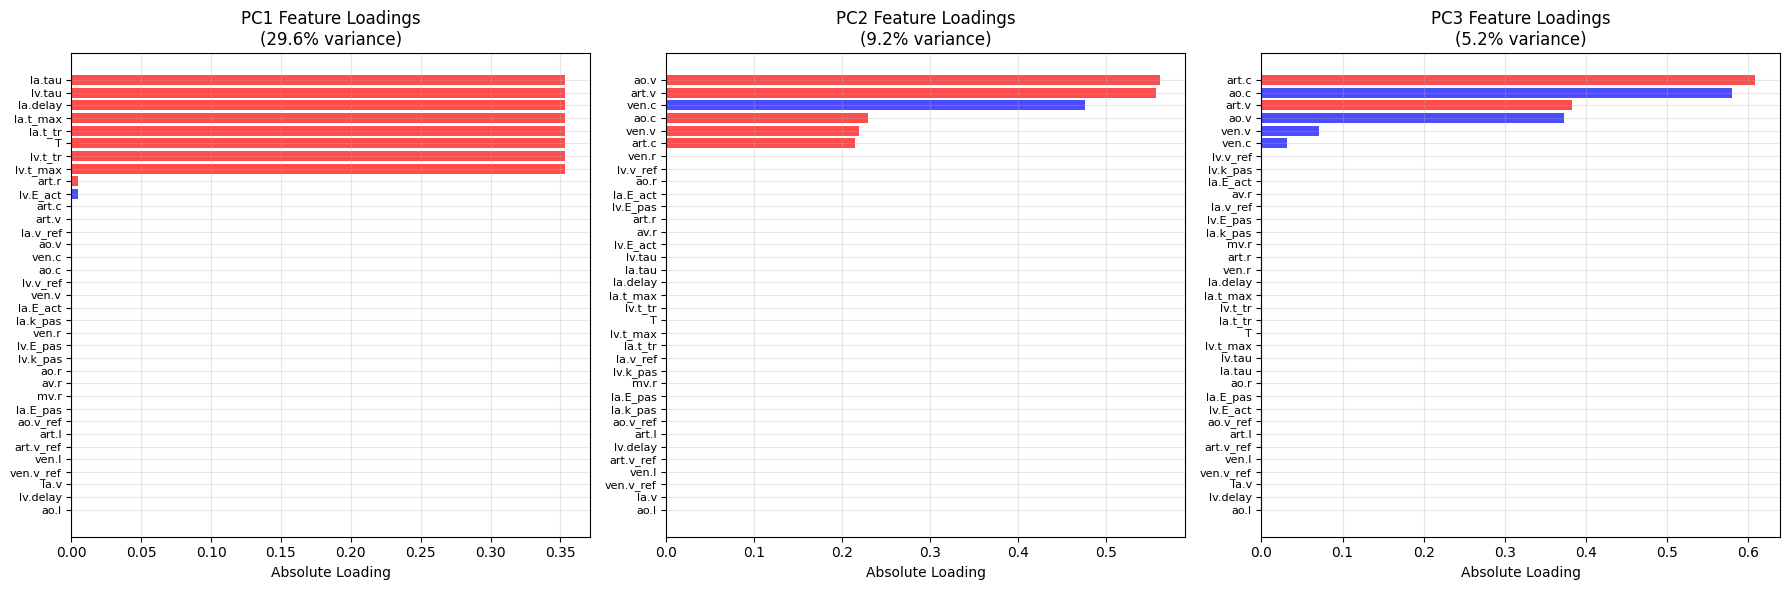

Top 5 features by absolute loading for each PC:

PC1:
  la.delay: 0.354
  la.tau: 0.354
  la.t_max: 0.354
  lv.tau: 0.354
  T: 0.354

PC2:
  ao.v: 0.562
  art.v: 0.557
  ven.c: 0.476
  ao.c: 0.230
  ven.v: 0.219

PC3:
  art.c: 0.609
  ao.c: 0.581
  art.v: 0.383
  ao.v: 0.373
  ven.v: 0.071


In [ ]:
# Get feature contributions to first few PCs
n_components = 3
feature_importance = pd.DataFrame(
    pca.components_[:n_components].T,
    columns=[f'PC{i+1}' for i in range(n_components)],
    index=param_cols
)

# Plot feature loadings
fig, axes = plt.subplots(1, n_components, figsize=(18, 6))

for i in range(n_components):
    pc_loadings = feature_importance[f'PC{i+1}'].abs().sort_values(ascending=True)
    
    ax = axes[i]
    colors = ['red' if x > 0 else 'blue' for x in feature_importance.loc[pc_loadings.index, f'PC{i+1}']]
    
    ax.barh(range(len(pc_loadings)), pc_loadings.values, color=colors, alpha=0.7)
    ax.set_yticks(range(len(pc_loadings)))
    ax.set_yticklabels(pc_loadings.index, fontsize=8)
    ax.set_xlabel('Absolute Loading')
    ax.set_title(f'PC{i+1} Feature Loadings\n({pca.explained_variance_ratio_[i]:.1%} variance)')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Top 5 features by absolute loading for each PC:")
for i in range(n_components):
    top_features = feature_importance[f'PC{i+1}'].abs().nlargest(5)
    print(f"\nPC{i+1}:")
    for feature, loading in top_features.items():
        print(f"  {feature}: {loading:.3f}")

## 6. Correlation Heatmap

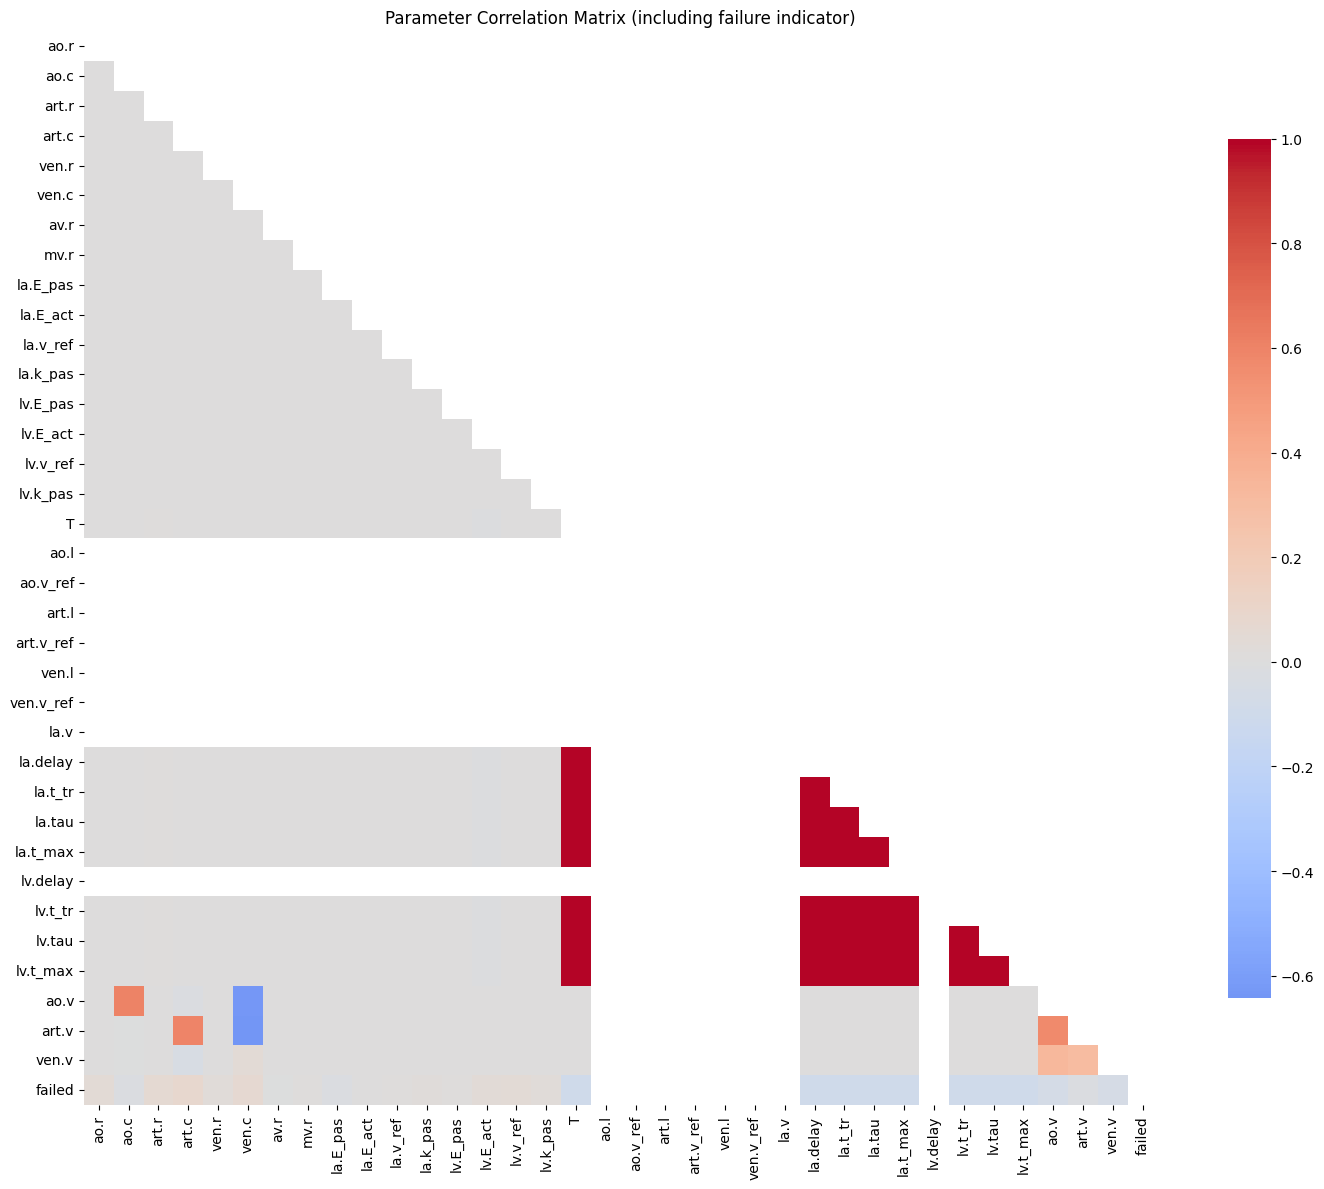

Parameters most correlated with failure:
la.t_max    0.098018
la.delay    0.098018
lv.tau      0.098018
la.tau      0.098018
T           0.098018
lv.t_max    0.098018
lv.t_tr     0.098018
la.t_tr     0.098018
art.c       0.081423
ven.c       0.064204
Name: failed, dtype: float64


In [ ]:
# Calculate correlation matrix
corr_matrix = df[param_cols + ['failed']].corr()

# Plot heatmap
plt.figure(figsize=(15, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Parameter Correlation Matrix (including failure indicator)')
plt.tight_layout()
plt.show()

# Show parameters most correlated with failure
failure_corr = corr_matrix['failed'].drop('failed').abs().sort_values(ascending=False)
print("Parameters most correlated with failure:")
print(failure_corr.head(10))

## 7. Parallel Coordinates Plot

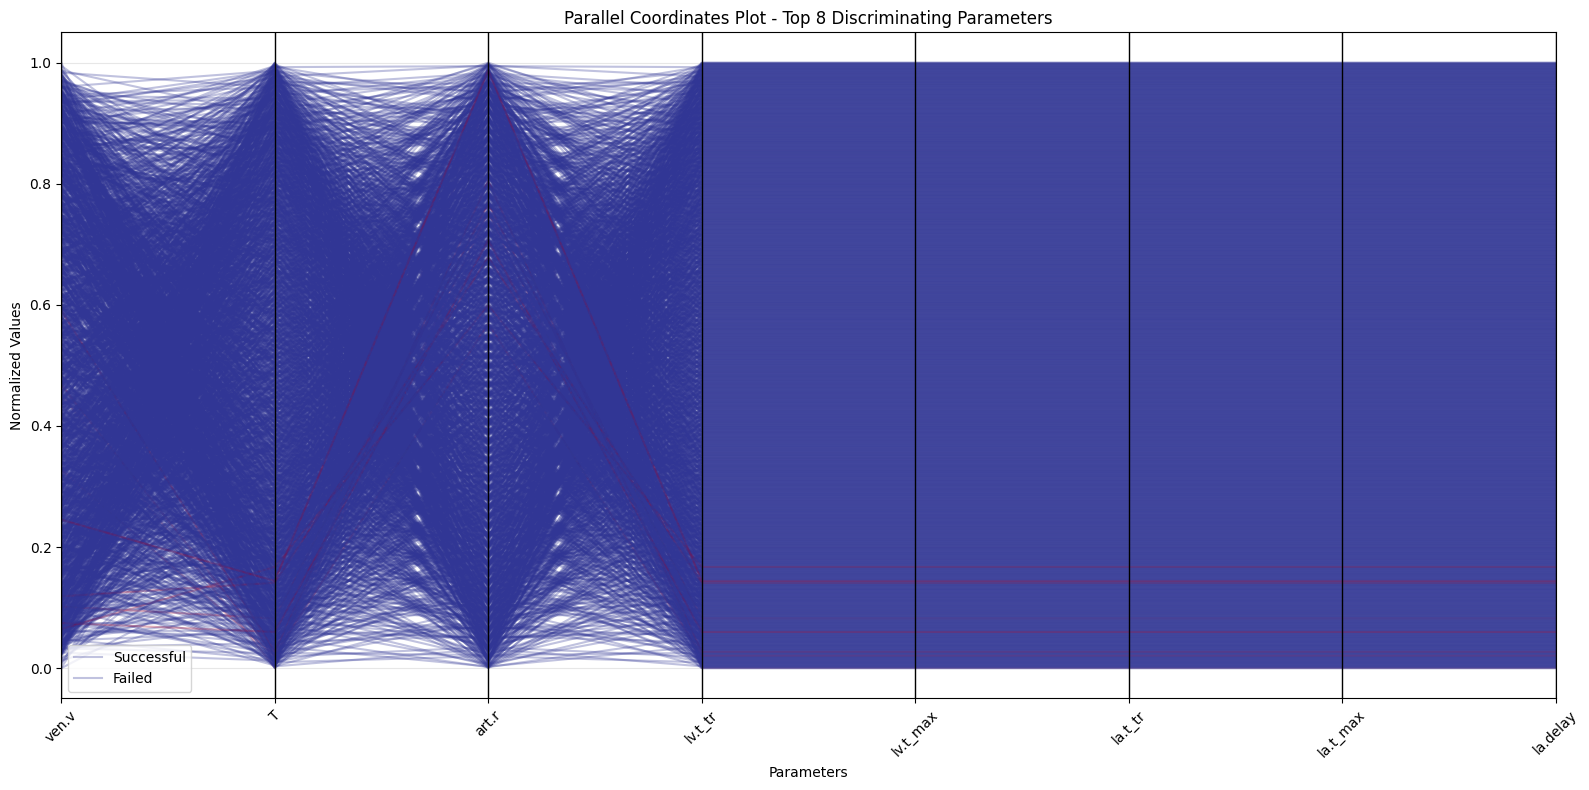

In [ ]:
from pandas.plotting import parallel_coordinates

# Select a subset of most important parameters for clarity
top_n = 8
important_params = stats_df.head(top_n)['Parameter'].tolist()

# Normalize the data for better visualization
df_normalized = df.copy()
for param in important_params:
    df_normalized[param] = (df[param] - df[param].min()) / (df[param].max() - df[param].min())

# Create parallel coordinates plot
plt.figure(figsize=(16, 8))
parallel_coordinates(df_normalized[important_params + ['failed']], 
                    'failed', 
                    colormap='RdYlBu_r',
                    alpha=0.3)
plt.title(f'Parallel Coordinates Plot - Top {top_n} Discriminating Parameters')
plt.xlabel('Parameters')
plt.ylabel('Normalized Values')
plt.xticks(rotation=45)
plt.legend(['Successful', 'Failed'])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Summary and Conclusions

In [ ]:
print("=" * 80)
print("SUMMARY OF FAILED SIMULATION ANALYSIS")
print("=" * 80)

print(f"\n📊 DATASET OVERVIEW:")
print(f"   • Total simulations: {len(df):,}")
print(f"   • Failed simulations: {len(failed_indices)} ({len(failed_indices)/len(df)*100:.2f}%)")
print(f"   • Number of parameters: {len(param_cols)}")

print(f"\n🔍 TOP 5 DISCRIMINATING PARAMETERS:")
for i, (_, row) in enumerate(stats_df.head(5).iterrows()):
    significance = "***" if row['T_Test_P_Value'] < 0.001 else "**" if row['T_Test_P_Value'] < 0.01 else "*" if row['T_Test_P_Value'] < 0.05 else ""
    print(f"   {i+1}. {row['Parameter']}: ")
    print(f"      Mean difference: {row['Mean_Difference']:+.4f} {significance}")
    print(f"      Failed avg: {row['Failed_Mean']:.4f}, Success avg: {row['Success_Mean']:.4f}")

print(f"\n📈 PCA INSIGHTS:")
print(f"   • First 3 PCs explain {sum(pca.explained_variance_ratio_[:3]):.1%} of variance")
print(f"   • Most important features in PC1: {', '.join(feature_importance['PC1'].abs().nlargest(3).index)}")

print(f"\n🎯 PARAMETERS MOST CORRELATED WITH FAILURE:")
top_corr = failure_corr.head(5)
for param, corr in top_corr.items():
    print(f"   • {param}: {corr:.4f}")

print(f"\n💡 RECOMMENDATIONS:")
print(f"   • Focus on the top discriminating parameters for model stability")
print(f"   • Consider parameter bounds or constraints for failure-prone regions")
print(f"   • The PCA visualization shows if failed cases cluster in parameter space")
print(f"   • Use the parallel coordinates plot to identify failure patterns")

SUMMARY OF FAILED SIMULATION ANALYSIS

📊 DATASET OVERVIEW:
   • Total simulations: 2,048
   • Failed simulations: 9 (0.44%)
   • Number of parameters: 35

🔍 TOP 5 DISCRIMINATING PARAMETERS:
   1. ven.v: 
      Mean difference: -695.2911 *
      Failed avg: 4175.9871, Success avg: 4871.2782
   2. T: 
      Mean difference: -384.9956 ***
      Failed avg: 366.6963, Success avg: 751.6919
   3. art.r: 
      Mean difference: +289.7540 **
      Failed avg: 1413.4807, Success avg: 1123.7267
   4. lv.t_tr: 
      Mean difference: -161.6981 ***
      Failed avg: 154.0124, Success avg: 315.7106
   5. lv.t_max: 
      Mean difference: -107.7988 ***
      Failed avg: 102.6750, Success avg: 210.4737

📈 PCA INSIGHTS:
   • First 3 PCs explain 44.0% of variance
   • Most important features in PC1: la.delay, la.tau, la.t_max

🎯 PARAMETERS MOST CORRELATED WITH FAILURE:
   • la.t_max: 0.0980
   • la.delay: 0.0980
   • lv.tau: 0.0980
   • la.tau: 0.0980
   • T: 0.0980

💡 RECOMMENDATIONS:
   • Focus on th